In [1]:
# Load libraries
import glob     
import numpy as np
import os

# manage file pathing
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Load pre-processing libraries
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch

# load custom libraries 
from src.pre_process_data import convert_all_images_from_png_to_jpg, build_train_df, process_data, stratified_random_shuffle_sampler
from src.model_training import load_pretrained_model
# load custom defined constants 
from model_config import CLASSES,WEIGHTS_CLASS_IMBALANCE,EARLYSTOP,OPTIMIZER,LR_SCHEDULER

# Visualisation
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set()
from sklearn.metrics import classification_report

# Constants
# Load the data path to images
IMG_DIR = '../data/train'
LABEL_FILENAME = 'labels.csv'

# Do note that since fixed seeds where not used there maybe viations in the exact values in terms of reproducibility.

# We will assume that all images are of .jpg or .png extensions

In [2]:
# convert any images that may be png
convert_all_images_from_png_to_jpg(IMG_DIR)
# generate train_df
train_df = build_train_df(IMG_DIR,LABEL_FILENAME)
print(train_df)
# show target names
CLASSES = list(train_df.category.unique())
print("Classes:", CLASSES)


No .png images found
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]
           image
0    1003035.jpg
1    1005343.jpg
2    1008439.jpg
3    1015027.jpg
4    1056555.jpg
..           ...
895   964374.jpg
896   977738.jpg
897   980701.jpg
898   986137.jpg
899   997951.jpg

[900 rows x 1 columns]
           image  category
0    2788353.jpg         0
1    2782131.jpg         0
2    2884349.jpg         0
3    2900596.jpg         0
4    2841543.jpg         0
..           ...       ...
895  2804619.jpg         4
896  2829250.jpg         4
897  2825240.jpg         4
898  2825172.jpg         4
899  2847678.jpg         4

[900 rows x 2 columns]
Classes: [0, 1, 2, 3, 4]


In [3]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# We will process our data to ensure that the file format is appopropriate for pytorch's ImageFolder
if not 'processed_data' in next(os.walk(IMG_DIR))[1] or not [str(i) for i in CLASSES] == next(os.walk(f"{IMG_DIR}/processed_data/"))[1]:
    process_data(train_df,IMG_DIR,CLASSES)

PROCESSED_DATA_PATH = f"{IMG_DIR}/processed_data/"
BATCH_SIZE = 64

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(PROCESSED_DATA_PATH, transform=transform)
print(train_dataset)

# randomly split train and validation data, we could also do a simple splice of 0.7 train - 0.3 validation
# It is assumed that the class distribution of the test data will be similar to the class distribtion of the training data
train_sampler, valid_sampler = stratified_random_shuffle_sampler(train_dataset, test_size=0.3, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, \
                              sampler=valid_sampler)
train_size =  len(train_sampler)
valid_size = len(valid_sampler)

Dataset ImageFolder
    Number of datapoints: 900
    Root location: ../data/train/processed_data/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomAffine(degrees=[-40.0, 40.0], scale=(1, 2), shear=[-15.0, 15.0])
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


c:\Users\USER\Anaconda3\envs\newenv\lib\site-packages\torchvision\transforms\transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
c:\Users\USER\Anaconda3\envs\newenv\lib\site-packages\torchvision\transforms\transforms.py:1443: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


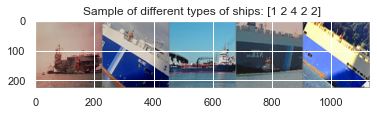

In [4]:
import torchvision
# Sample some of our training data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from subset of batch
out = torchvision.utils.make_grid(inputs[0:5])
imshow(out,title=f"Sample of different types of ships: {classes[0:5].numpy()}")

# Import and train model

In [5]:
# Use cuda to enable gpu usage for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# load model
model_ft = load_pretrained_model(model_name='vgg16', classes=CLASSES, device=device)
print(model_ft)

cpu


c:\Users\USER\Anaconda3\envs\newenv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\USER\Anaconda3\envs\newenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
def weight_builder(IMG_DIR, clss_lst, data_size):
  weights = []
  for clss in clss_lst:
    num_of_samples = len(glob.glob(f"{IMG_DIR}/processed_data/{clss}/*jpg")) 
    weights.append(1 / (num_of_samples / data_size))
  return weights

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [7]:
if WEIGHTS_CLASS_IMBALANCE:
    # Create weights to handle class imbalance (Used later)
    weights = weight_builder(IMG_DIR, CLASSES, train_size)
    print("Weight balanced is used.")
    print("Re-weight distribution:",weights)
    loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
else:
    print("No Weight balanced is used.")
    loss_fn = nn.CrossEntropyLoss()
if EARLYSTOP:
    print("Early stopping is enabled.")
    # Add early stopping as a regularizer for overfitting
    early_stopping = EarlyStopping(tolerance=5, min_delta=10)
if OPTIMIZER == 'Adam':
    print("Optimiser used:", OPTIMIZER)
    # We will use ADAM as our opitimiser to learn the optimal amount of gradient descent
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
else:
    print("Optimiser used: SGD")
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)
if LR_SCHEDULER == 'Step':
    print("learning rate scheduler used: Step")
    # Exponentially Decay LR by a factor of 0.1
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
else:
    print("lr scheduler not found")

No Weight balanced is used.
Early stopping is enabled.
Optimiser used: Adam
learning rate scheduler used: Step


In [25]:
import time
import copy
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=100):
    since = time.perf_counter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9800 Acc: 0.5984
val Loss: 0.9158 Acc: 0.6741

Epoch 1/24
----------
train Loss: 0.8951 Acc: 0.6651
val Loss: 0.8849 Acc: 0.6815

Epoch 2/24
----------
train Loss: 0.8525 Acc: 0.6810
val Loss: 0.8058 Acc: 0.7037

Epoch 3/24
----------
train Loss: 0.8669 Acc: 0.6619
val Loss: 0.7880 Acc: 0.7593

Epoch 4/24
----------
train Loss: 0.8223 Acc: 0.6952
val Loss: 0.8691 Acc: 0.6741

Epoch 5/24
----------
train Loss: 0.8122 Acc: 0.6968
val Loss: 0.8429 Acc: 0.7037

Epoch 6/24
----------
train Loss: 0.8403 Acc: 0.7095
val Loss: 0.8346 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.7935 Acc: 0.6825
val Loss: 0.7502 Acc: 0.7259

Epoch 8/24
----------
train Loss: 0.7784 Acc: 0.6730
val Loss: 0.7632 Acc: 0.7111

Epoch 9/24
----------
train Loss: 0.7432 Acc: 0.7333
val Loss: 0.7763 Acc: 0.7222

Epoch 10/24
----------
train Loss: 0.7818 Acc: 0.7127
val Loss: 0.6712 Acc: 0.7815

Epoch 11/24
----------
train Loss: 0.7274 Acc: 0.7127
val Loss: 0.7240 Acc: 0.7444

Ep

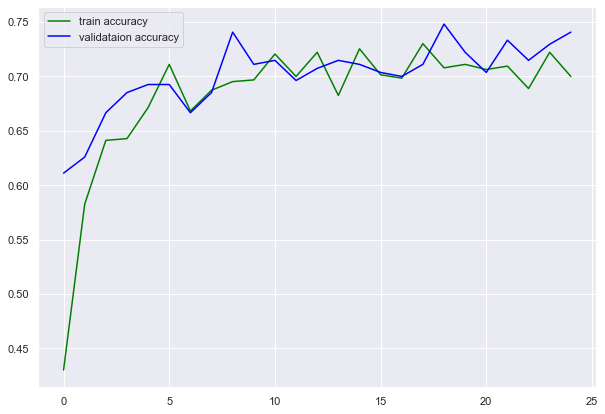

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('../images/train_val_accuracy.png')
plt.show()

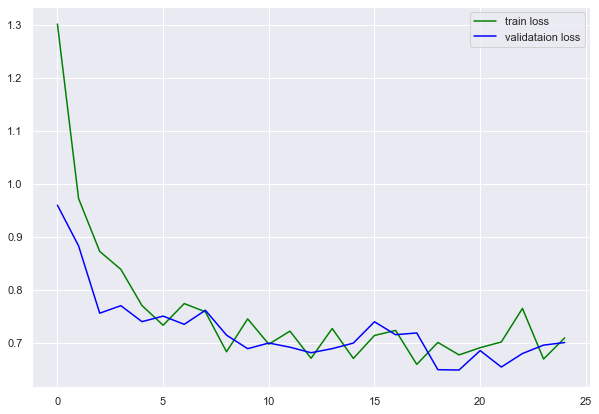

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validataion loss')
plt.legend()
plt.savefig('../images/train_val_loss.png')
plt.show()

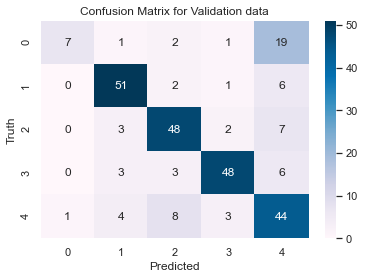

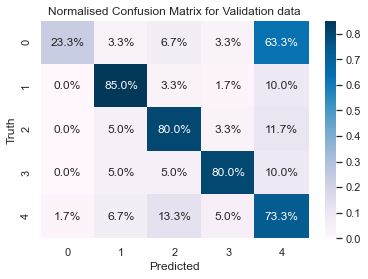

Analysis
Taking a look at our normalised confusion Model Evaluation, we see that many of the '0' class has been predicted as as the '4' class. As 63.33% of all Validation '0' classe was predicted as '4'. 


In [13]:
nb_classes = len(CLASSES)

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

sns.heatmap(confusion_matrix, annot=True, cmap='PuBu')
plt.title("Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

normalised_cm = confusion_matrix.numpy()/np.sum(confusion_matrix.numpy(),axis=1)[:, np.newaxis]

sns.heatmap(normalised_cm,fmt='.1%', annot=True, cmap='PuBu')
plt.title("Normalised Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

print("Analysis")
print(f"Taking a look at our normalised confusion Model Evaluation, we see that many of the '0' class has been predicted as as the '4' class. As {round(normalised_cm[0][-1]*100,2)}% of all Validation '0' classe was predicted as '4'. ")

In [14]:
truth = []
pred = []

with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        pred.extend(preds.view(-1).tolist())
        truth.extend(classes.view(-1).tolist())

print(classification_report(truth, pred))

print("The low precision score but high recall value for 0, could be due to '0' being a minority class, where there are fewer postive examples to become false negatives, while there are many negative examples that could become false positives")

              precision    recall  f1-score   support

           0       1.00      0.13      0.24        30
           1       0.80      0.80      0.80        60
           2       0.75      0.83      0.79        60
           3       0.80      0.85      0.82        60
           4       0.59      0.73      0.65        60

    accuracy                           0.73       270
   macro avg       0.79      0.67      0.66       270
weighted avg       0.76      0.73      0.71       270

The low precision score but high recall value for 0, could be due to '0' being a minority class, where there are fewer postive examples to become false negatives, while there are many negative examples that could become false positives


In [33]:
# saving model (TorchScript) Using TorchScript allows for simpler deployment
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
model_scripted.save('../models/VGG16_v2_train.pt')

# saving model (state dict)
# torch.save(model_ft.state_dict(), '../models/VGG16_v4_class_weights.pt')

## Class Weights Model

In [60]:
# Load previously saved model
model_ft = torch.jit.load('../models/VGG16_v4_class_weights.pt')
model_ft.to(device)

RecursiveScriptModule(
  original_name=VGG
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=MaxPool2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=ReLU)
    (16): RecursiveScriptModule(original_name

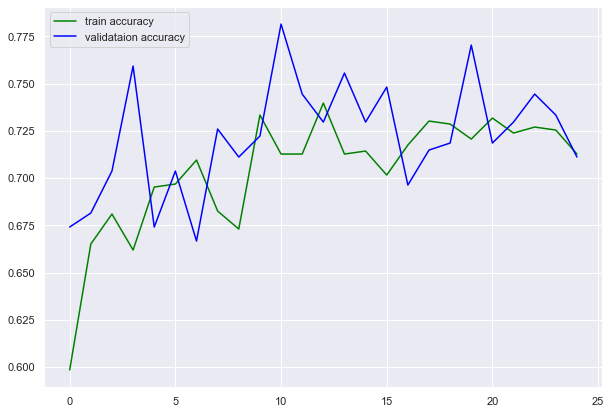

In [26]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.title("Train vs Validation accuracy")
plt.legend()
plt.savefig('../images/class_weight_train_val_accuracy.png')
plt.show()

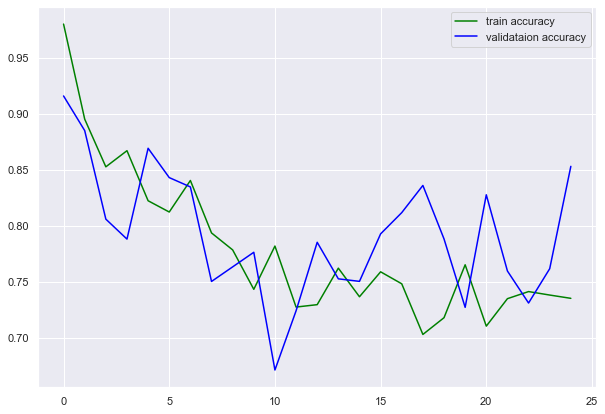

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train accuracy')
plt.plot(plot_val_loss, color='blue', label='validataion accuracy')
plt.title("Train vs Validation loss")
plt.legend()
plt.savefig('../images/class_weight_train_val_loss.png')
plt.show()

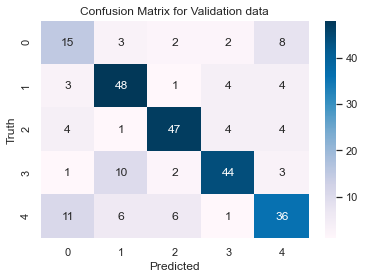

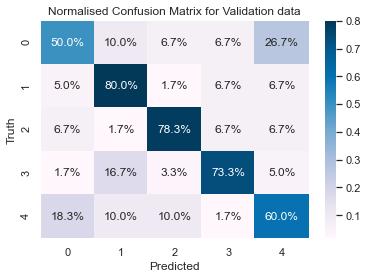

Analysis
We see that with re-balancing weights, there is a drop in misclassifications from the '0' class to the '4' class


In [36]:
nb_classes = len(CLASSES)

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

sns.heatmap(confusion_matrix, annot=True, cmap='PuBu')
plt.title("Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

normalised_cm = confusion_matrix.numpy()/np.sum(confusion_matrix.numpy(),axis=1)[:, np.newaxis]

sns.heatmap(normalised_cm,fmt='.1%', annot=True, cmap='PuBu')
plt.title("Normalised Confusion Matrix for Validation data")
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

print("Analysis")
print("We see that with re-balancing weights, there is a drop in misclassifications from the '0' class to the '4' class")

In [29]:
truth = []
pred = []

with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        pred.extend(preds.view(-1).tolist())
        truth.extend(classes.view(-1).tolist())

print(classification_report(truth, pred))

              precision    recall  f1-score   support

           0       0.48      0.53      0.51        30
           1       0.79      0.82      0.80        60
           2       0.83      0.73      0.78        60
           3       0.87      0.90      0.89        60
           4       0.62      0.62      0.62        60

    accuracy                           0.74       270
   macro avg       0.72      0.72      0.72       270
weighted avg       0.74      0.74      0.74       270



In [38]:
print('Analysis')
print("There are also improvements to the overal prediction of all classes")

Analysis
There are also improvements to the overal prediction of all classes


In [ ]:
# Future Work
